# <center> Сегментация клиентов онлайн магазина подарков

## Постановка задачи

## Данные и их описание

Данные представляют собой таблицу в формате CSV, в каждой строке которой содержится информация об уникальной транзакции.

Признаки, описывающие каждую транзакцию:

* InvoiceNo — номер счёта-фактуры (уникальный номинальный шестизначный номер, присваиваемый каждой транзакции; буква "C" в начале кода указывает на отмену транзакции);
* StockCode — код товара (уникальное пятизначное целое число, присваиваемое каждому отдельному товару);
* Description — название товара;
* Quantity — количество каждого товара за транзакцию;
* InvoiceDate — дата и время выставления счёта/проведения транзакции;
* UnitPrice — цена за единицу товара в фунтах стерлингов;
* CustomerID — идентификатор клиента (уникальный пятизначный номер, однозначно присваиваемый каждому клиенту);
* Country — название страны, в которой проживает клиент.



In [106]:
import warnings

import numpy as np
import pandas as pd
import re
import seaborn as sns
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
from sklearn.cluster import (AgglomerativeClustering, KMeans, SpectralClustering, 
                              DBSCAN, Birch)
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform


# Настройка предупреждений
warnings.filterwarnings("ignore")
plt.rcParams["patch.force_edgecolor"] = True

## 1. Знакомство со структурой данных

In [62]:
main_data = pd.read_csv(
    "data.csv", 
    encoding="ISO-8859-1", 
    dtype={'CustomerID': str,'InvoiceID': str}
)
data = main_data.copy()
print('Data shape: {}'.format(data.shape))
data.head(5)

Data shape: (541909, 8)


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850,United Kingdom


In [63]:
data['InvoiceDate'] = pd.to_datetime(data['InvoiceDate'])
print(f'Временной интервал составляет: {data["InvoiceDate"].dt.date.min()}:{data["InvoiceDate"].dt.date.max()}')

Временной интервал составляет: 2010-12-01:2011-12-09


## 2. Преобразование, очистка и анализ данных

In [64]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    541909 non-null  object        
 1   StockCode    541909 non-null  object        
 2   Description  540455 non-null  object        
 3   Quantity     541909 non-null  int64         
 4   InvoiceDate  541909 non-null  datetime64[ns]
 5   UnitPrice    541909 non-null  float64       
 6   CustomerID   406829 non-null  object        
 7   Country      541909 non-null  object        
dtypes: datetime64[ns](1), float64(1), int64(1), object(5)
memory usage: 33.1+ MB


In [65]:
data[data.isna().any(axis=1)].head(10)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
622,536414,22139,NaN,56,2010-12-01 11:52:00,0.00,NaN,United Kingdom
1443,536544,21773,DECORATIVE ROSE BATHROOM BOTTLE,1,2010-12-01 14:32:00,2.51,NaN,United Kingdom
1444,536544,21774,DECORATIVE CATS BATHROOM BOTTLE,2,2010-12-01 14:32:00,2.51,NaN,United Kingdom
1445,536544,21786,POLKADOT RAIN HAT,4,2010-12-01 14:32:00,0.85,NaN,United Kingdom
1446,536544,21787,RAIN PONCHO RETROSPOT,2,2010-12-01 14:32:00,1.66,NaN,United Kingdom
1447,536544,21790,VINTAGE SNAP CARDS,9,2010-12-01 14:32:00,1.66,NaN,United Kingdom
1448,536544,21791,VINTAGE HEADS AND TAILS CARD GAME,2,2010-12-01 14:32:00,2.51,NaN,United Kingdom
1449,536544,21801,CHRISTMAS TREE DECORATION WITH BELL,10,2010-12-01 14:32:00,0.43,NaN,United Kingdom
1450,536544,21802,CHRISTMAS TREE HEART DECORATION,9,2010-12-01 14:32:00,0.43,NaN,United Kingdom
1451,536544,21803,CHRISTMAS TREE STAR DECORATION,11,2010-12-01 14:32:00,0.43,NaN,United Kingdom


In [66]:
data.dropna(inplace=True)
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 406829 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    406829 non-null  object        
 1   StockCode    406829 non-null  object        
 2   Description  406829 non-null  object        
 3   Quantity     406829 non-null  int64         
 4   InvoiceDate  406829 non-null  datetime64[ns]
 5   UnitPrice    406829 non-null  float64       
 6   CustomerID   406829 non-null  object        
 7   Country      406829 non-null  object        
dtypes: datetime64[ns](1), float64(1), int64(1), object(5)
memory usage: 27.9+ MB


In [67]:
data.drop_duplicates(inplace=True) 
print(data.shape)

(401604, 8)


#### 2.1.3. Транзакции с отрицательным количеством товара

Из приведённых выше инсайтов о данных мы узнали все особенности отмены заказов. Когда мы будем сегментировать клиентов, мы будем определять их покупательскую способность. При расчёте покупательской способности нам будет очень важно учесть возвраты этого клиента.

Чтобы подсчитать количество возвратов, для начала нам надо определить, сколько уникальных товаров указано в транзакции (корзине) для каждой уникальной пары «клиент — заказ»:


In [68]:
temp = data.groupby(by=['CustomerID', 'InvoiceNo'], as_index=False)['InvoiceDate'].count()
nb_products_per_basket = temp.rename(columns = {'InvoiceDate':'Number of products'})
nb_products_per_basket['Number of products'].describe()

count    22190.000000
mean        18.098423
std         23.363888
min          1.000000
25%          3.000000
50%         12.000000
75%         24.000000
max        542.000000
Name: Number of products, dtype: float64

**Примечание.** Более 16 % уникальных заказов являются возвратами. Интересный факт: если мы подсчитали количество транзакций, содержащих признак возврата, в изначальной таблице, где на каждый уникальный товар заведена отдельная строка, то мы получили бы, что количество возвратов менее 1 %. Однако это число было бы некорректным.

In [69]:
quantity_canceled = pd.Series(np.zeros(data.shape[0]), index=data.index)    
negative_quantity = data[(data['Quantity'] < 0)].copy()
negative_quantity.head(2)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
141,C536379,D,Discount,-1,2010-12-01 09:41:00,27.50,14527,United Kingdom
154,C536383,35004C,SET OF 3 COLOURED FLYING DUCKS,-1,2010-12-01 09:49:00,4.65,15311,United Kingdom


In [70]:
def get_quantity_canceled(data: pd.DataFrame) -> pd.Series:
    """
    Функция для создания признака количества отменённых заказов. 
    Функция принимает на вход таблицу и возвращает столбец, в котором указано количество отменённого впоследствии товара для кажой транзакции.
    Если транзакция с отрицательным количеством товара не имеет контрагента, данный признак помечается как NaN.
    """

    quantity_canceled = pd.Series(np.zeros(data.shape[0]), index=data.index)    
    negative_quantity = data[(data['Quantity'] < 0)].copy()

    for index, col in negative_quantity.iterrows():
        df_test = data[(data['CustomerID'] == col['CustomerID']) &
                       (data['StockCode']  == col['StockCode']) & 
                       (data['InvoiceDate'] < col['InvoiceDate']) & 
                       (data['Quantity'] > 0)].copy()
      
        if (df_test.shape[0] == 0): 
            quantity_canceled.loc[index] = np.nan
        elif (df_test.shape[0] == 1): 
            index_order = df_test.index[0]
            quantity_canceled.loc[index_order] = -col['Quantity']      
        elif (df_test.shape[0] > 1): 
            df_test.sort_index(axis=0 ,ascending=False, inplace = True)        
            for ind, val in df_test.iterrows():
                if val['Quantity'] < -col['Quantity']: 
                    continue
                quantity_canceled.loc[ind] = -col['Quantity']
                break    
            
    return quantity_canceled

data['QuantityCanceled'] = get_quantity_canceled(data)

In [71]:
main_data = data.copy()

In [72]:
data = main_data.copy()

In [73]:
data = data[data['Quantity'].ge(0) | data['Quantity'].isna()]
data.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,QuantityCanceled
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850,United Kingdom,0.0
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,0.0
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850,United Kingdom,0.0
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,0.0
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,0.0


#### 2.1.4. Специализированные транзакции

In [74]:
def special_code(code: str) -> bool:
    """Функция для проверки наличия латинской буквы в начале кода"""
    return bool(re.match(r'^[a-zA-Z]+', str(code)))


data['special_code'] = data['StockCode'].apply(special_code)
filtered_df = data[data['special_code']]

filtered_df['StockCode'].value_counts()

StockCode
POST            1099
M                285
C2               133
DOT               16
BANK CHARGES      12
PADS               4
Name: count, dtype: int64

#### 2.1.5. Транзакции с товарами без стоимости

При просмотре описательных статистик можно заметить, что на некоторые товары установлена цена в 0 фунтов стерлингов. Таких транзакций оказывается менее 1 % — можно удалить их.

In [75]:
data = data[data['UnitPrice']!=0]
data.shape

(392692, 10)

#### 2.1.6. Общая стоимость товаров в транзакции

In [76]:
def final_price(row: pd.Series) -> float:
    return row['UnitPrice']*(row['Quantity']-row['QuantityCanceled'])

data['final_price'] = data.apply(final_price, axis = 1)


### 2.2. Разведывательный анализ

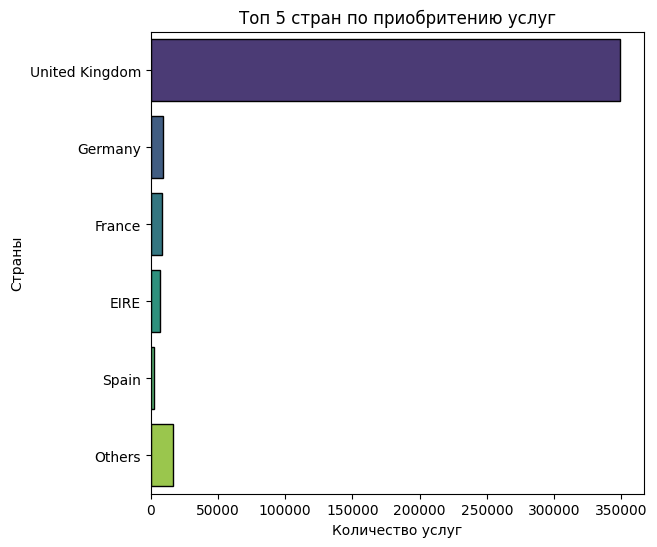

In [77]:

import kaleido
import plotly


df = data['Country'].value_counts().reset_index().sort_values('count', ascending=False)
top_data = df.nlargest(5, 'count')
temporary_data = pd.DataFrame({'Country': ['Others'], 'count': [df[~df['Country'].isin(top_data['Country'])]['count'].sum()]})


df_summary = pd.concat([top_data, temporary_data], ignore_index=True)

plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
sns.barplot(x='count', y='Country', data=df_summary, palette='viridis')
plt.title('Топ 5 стран по приобритению услуг')
plt.xlabel('Количество услуг')
plt.ylabel('Страны')

plt.show()

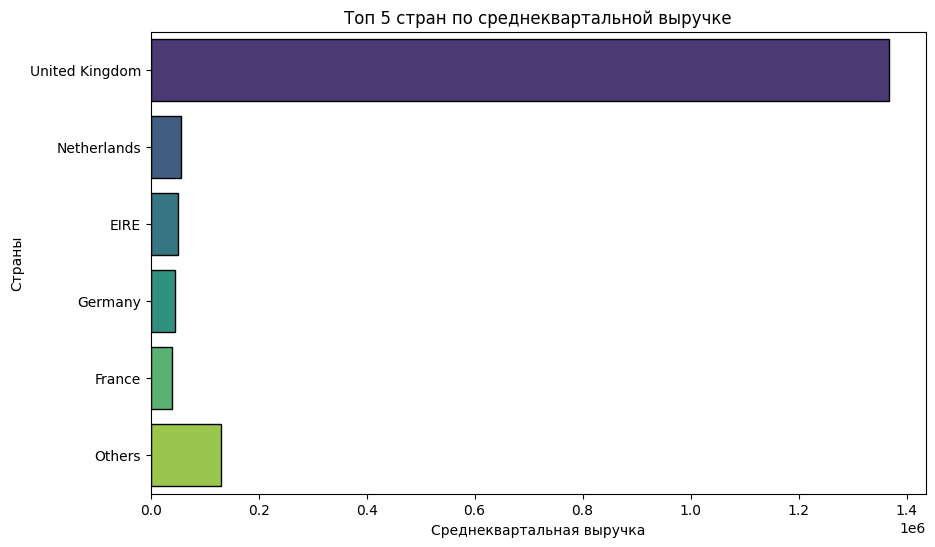

In [78]:
data['quarter'] = data['InvoiceDate'].dt.to_period('Q')
quarterly_revenue = data.groupby(['Country', 'quarter'])['final_price'].sum().reset_index()

total_quarterly_revenue = (
    quarterly_revenue.groupby('Country')['final_price']
    .mean()
    .reset_index()
    .sort_values("final_price", ascending=False)
    )

top_data = total_quarterly_revenue.nlargest(5, 'final_price')
temporary_data = pd.DataFrame({'Country': ['Others'], 'final_price': [total_quarterly_revenue[~total_quarterly_revenue['Country'].isin(top_data['Country'])]['final_price'].sum()]})

df_summary = pd.concat([top_data, temporary_data], ignore_index=True)
plt.figure(figsize=(10, 6))

# Столбчатая диаграмма для отображения топ-5 стран
sns.barplot(x='final_price', y='Country', data=df_summary, palette='viridis')

plt.title('Топ 5 стран по среднеквартальной выручке')
plt.xlabel('Среднеквартальная выручка')
plt.ylabel('Страны')

plt.show()

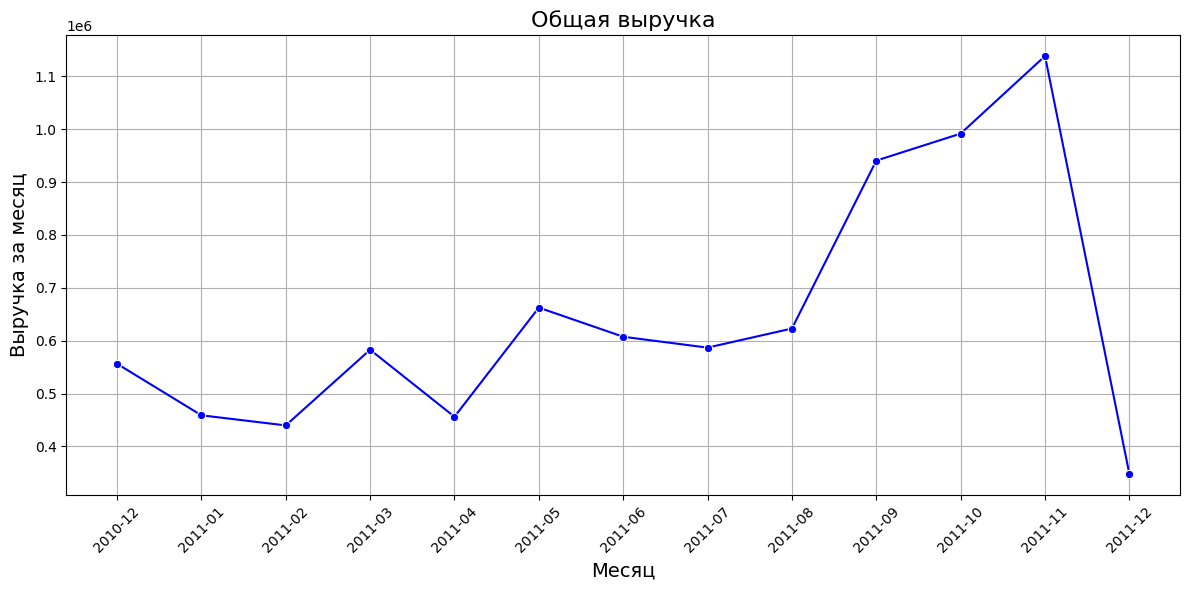

In [79]:
data['month'] =  data['InvoiceDate'].dt.to_period('M').astype('str')
sezon_data = data.groupby('month')['final_price'].sum().reset_index()

plt.figure(figsize=(12, 6))


sns.lineplot(data=sezon_data, x='month', y='final_price', marker='o', color='b')

plt.title('Общая выручка', fontsize=16)
plt.xlabel('Месяц', fontsize=14)
plt.ylabel('Выручка за месяц', fontsize=14)
plt.xticks(rotation=45) 
plt.grid()  
plt.tight_layout()  

plt.show()



В осенне время явно наблюдается повышение выручки магазина. Это может быть связано с праздниками, или же с подготовкой к будущим праздникам
Так как подавляющее число покупок совершают в британии, проверим именно эту страну

In [80]:
data[(data['month']=='2011-11') & (data['Country'] == 'United Kingdom')]['Description'].value_counts().head()

Description
RABBIT NIGHT LIGHT                   376
PAPER CHAIN KIT 50'S CHRISTMAS       339
HOT WATER BOTTLE KEEP CALM           255
PAPER CHAIN KIT VINTAGE CHRISTMAS    232
JUMBO BAG 50'S CHRISTMAS             218
Name: count, dtype: int64

Что и требовалось доказать. В топ 5 входит целых 3 товара предназначенные для подготовки к Рождеству 

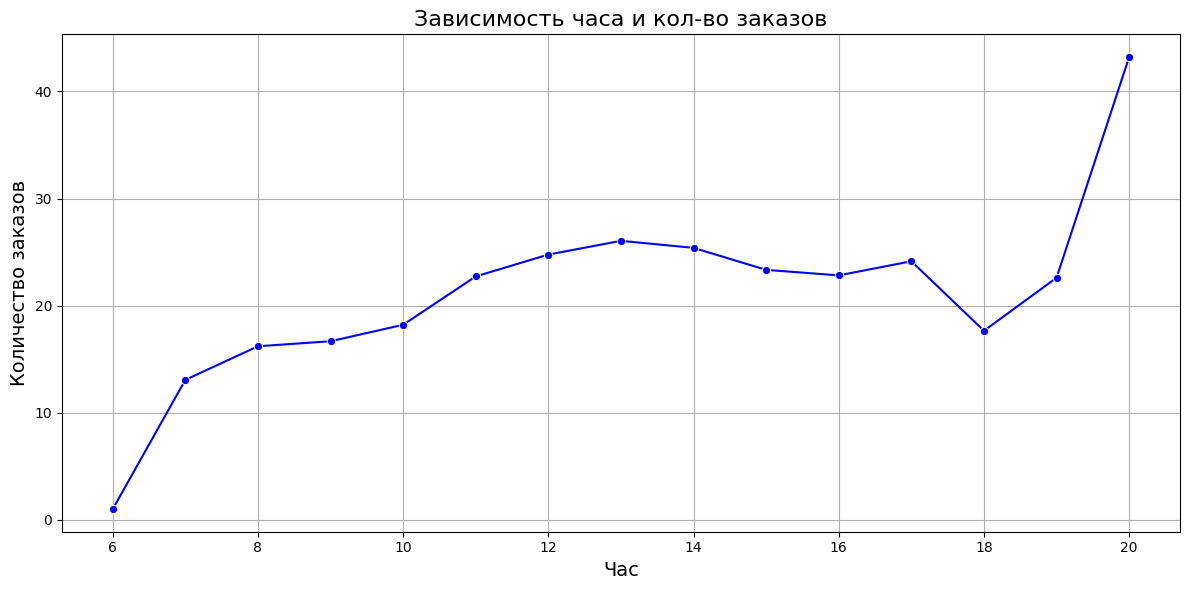

In [81]:
data['hour'] = data['InvoiceDate'].dt.hour
time_data = data.groupby(['InvoiceDate', 'hour']).size().reset_index(name='order_count')

average_orders_per_hour = time_data.groupby('hour')['order_count'].mean().reset_index()

plt.figure(figsize=(12, 6))

# Линейный график для отображения зависимости количества заказов от часа
sns.lineplot(data=average_orders_per_hour, x='hour', y='order_count', marker='o', color='b')

plt.title('Зависимость часа и кол-во заказов', fontsize=16)
plt.xlabel('Час', fontsize=14)
plt.ylabel('Количество заказов', fontsize=14)
plt.xticks(rotation=0)  
plt.grid() 
plt.tight_layout()

plt.show()

График имеет явный тренд на повышение

### 2.3. Построение RFM-таблицы и поиск RFM-выбросов

Чтобы получить RFM-таблицу, нам необходимо сгруппировать данные по идентификаторам клиента и рассчитать следующие  агрегированные характеристики:

* Recency для i-го клиента рассчитывается как разница между датой и временем последнего заказа и точкой отсчёта, переведённая в дни:
    $$t_0-max(t_{i1}, t_{i2},..., t_{iM})$$

    где $t_{ij}$ — дата и время совершения i-ым клиентом своей j-ой покупки.

    В качестве точки отсчёта $t_0$ берём дату на один день «старше», чем все наши данные. Это будет 10 декабря 2011 года (в формате datetime — '2011-12-10 00:00:00').

* Frequency рассчитывается как общее количество уникальных заказов, которые совершил i-ый клиент.
* Monetary Value рассчитывается как общая сумма денег, которую i-ый клиент потратил на наши товары (с учётом возвратов).

Recency

In [82]:
Recency = (pd.to_datetime('2011-12-10 00:00:00') - data.groupby('CustomerID')['InvoiceDate'].max()).reset_index()
Frequency = data.groupby('CustomerID')['Description'].nunique().reset_index()
Monetery_Value = data.groupby('CustomerID')['final_price'].sum().reset_index()


rfm = pd.merge(Recency, Frequency, on='CustomerID')
rfm = pd.merge(rfm, Monetery_Value, on='CustomerID')
rfm.set_index('CustomerID', inplace=True)
rfm.columns = ['Recency', 'Frequency', 'Monetery']

Теперь визуализируем все 3 переменные в коробчатой диаграмме

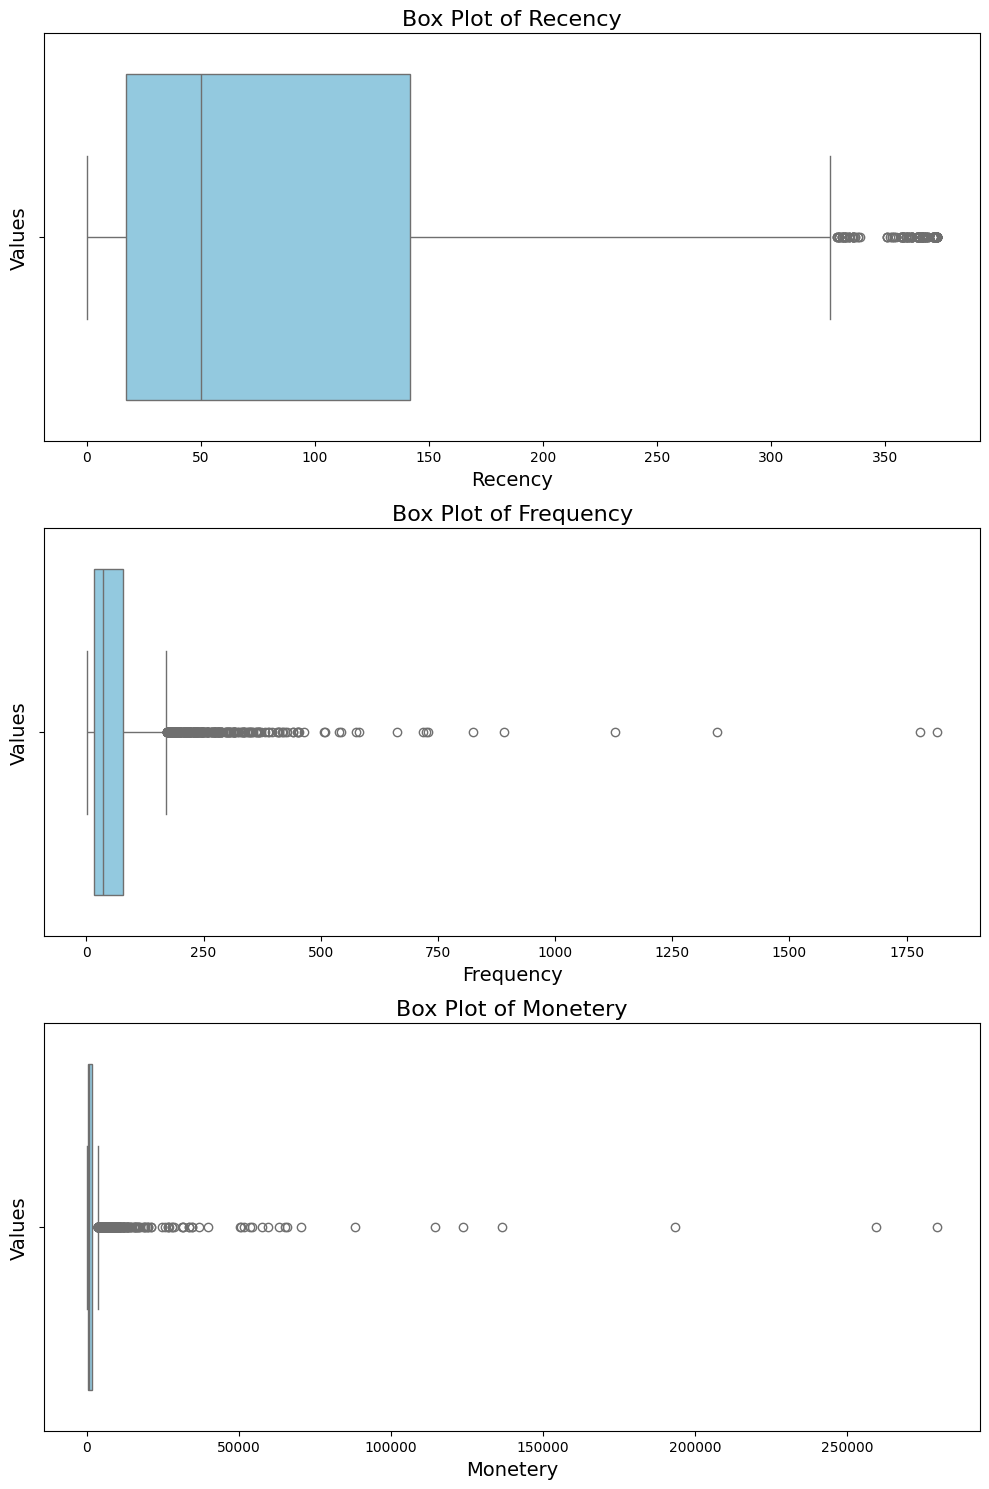

In [83]:
rfm['Recency'] = rfm['Recency'].dt.days


fig, axes = plt.subplots(nrows=len(rfm.columns), ncols=1, figsize=(10, 15))

for i, column in enumerate(rfm.columns):
    # Создание box plot для каждого столбца
    sns.boxplot(data=rfm, x=column, ax=axes[i], color='skyblue')
    axes[i].set_title(f'Box Plot of {column}', fontsize=16)
    axes[i].set_xlabel(column, fontsize=14)
    axes[i].set_ylabel('Values', fontsize=14)

plt.tight_layout() 
plt.show()  

### Анализ выбросов в данных о клиентах

В процессе анализа данных о клиентах мы обнаружили несколько интересных моментов:

- Есть клиенты с аномально большим количеством сделанных заказов (более 100 штук).
- Также есть клиенты, общая стоимость заказов которых превышает 190 тысяч фунтов стерлингов.

#### Потенциальные проблемы с выбросами

Наличие выбросов может негативно сказаться на работе методов кластеризации, особенно тех, которые неустойчивы к ним, таких как алгоритм KMeans. Это может привести к неправильным выводам и ухудшению качества модели.

#### Предложенное решение

Чтобы справиться с этой проблемой, мы планируем удалить данные о клиентах с выбросами. Однако важно не потерять слишком много ценной информации. Поэтому мы ограничимся верхней границей, соответствующей квантили уровня 0.95. 

Таким образом, мы удалим данные тех клиентов, для которых значение параметров **Frequency** или **Monetary** выше, чем у 95% клиентов.


In [84]:
frequency_95_percentile = rfm['Frequency'].quantile(0.95)
monetary_95_percentile = rfm['Monetery'].quantile(0.95)

# 2. Фильтрация данных, исключая значения выше 95-го перцентиля
rfm = rfm[
    (rfm['Frequency'] <= frequency_95_percentile) &
    (rfm['Monetery'] <= monetary_95_percentile)
]

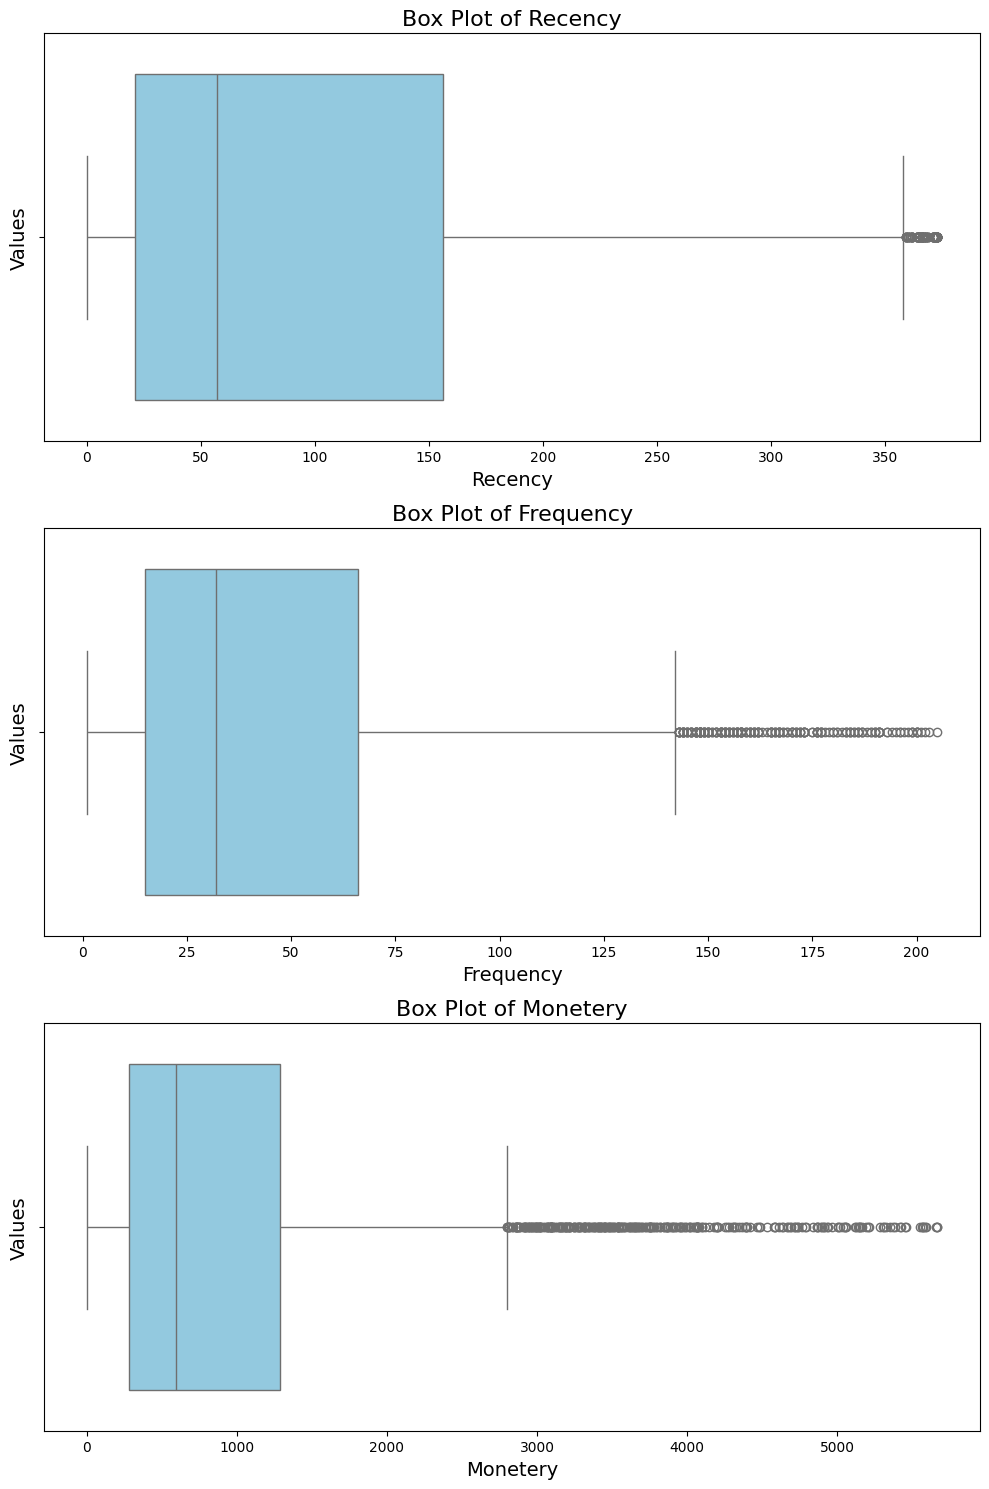

In [85]:
fig, axes = plt.subplots(nrows=len(rfm.columns), ncols=1, figsize=(10, 15))

for i, column in enumerate(rfm.columns):
    # Создание box plot для каждого столбца
    sns.boxplot(data=rfm, x=column, ax=axes[i], color='skyblue')
    axes[i].set_title(f'Box Plot of {column}', fontsize=16)
    axes[i].set_xlabel(column, fontsize=14)
    axes[i].set_ylabel('Values', fontsize=14)

plt.tight_layout() 
plt.show()  

## 3. Моделирование и оценка качества моделей

### 3.1. Кластеризация на основе RFM-характеристик

In [86]:
main_rfm = rfm.copy()

In [87]:
pipeline = Pipeline(steps=[
    ('scaler', StandardScaler()),   
    ('pca', PCA(n_components=2))  
])

rfm = pipeline.fit_transform(rfm)

In [88]:

def line_silhouette_score(silhouette_scores: np.ndarray) -> None:
    """Строит график коэффициента силуэта для выбора количества кластеров."""
    
    df_scores = pd.DataFrame({
        'N_clusters': range(3, 11),  
        'Score': silhouette_scores
    })

    plt.figure(figsize=(10, 6))
    sns.lineplot(data=df_scores, x='N_clusters', y='Score', marker='o')
    
    plt.title('Выбор количества кластеров по коэффициенту силуэта', fontsize=16)
    plt.xlabel('Кол-во кластеров', fontsize=12)
    plt.ylabel('Коэф. Силуэта', fontsize=12)
    plt.xticks(df_scores['N_clusters'])
    plt.grid()
    plt.show()

def scatter_px(data: np.ndarray, clusters: np.ndarray) -> None:
    """Строит рассеянный график с раскраской по кластерам."""
    
    df = pd.DataFrame(data, columns=['Feature 1', 'Feature 2'])
    df['Cluster'] = clusters
   
    plt.figure(figsize=(10, 6))
    sns.scatterplot(data=df, x='Feature 1', y='Feature 2', hue='Cluster', palette='viridis', s=100)
    
    plt.title('Cluster Visualization', fontsize=16)
    plt.xlabel('Feature 1', fontsize=12)
    plt.ylabel('Feature 2', fontsize=12)
    plt.legend(title='Cluster')
    plt.grid()
    plt.show()

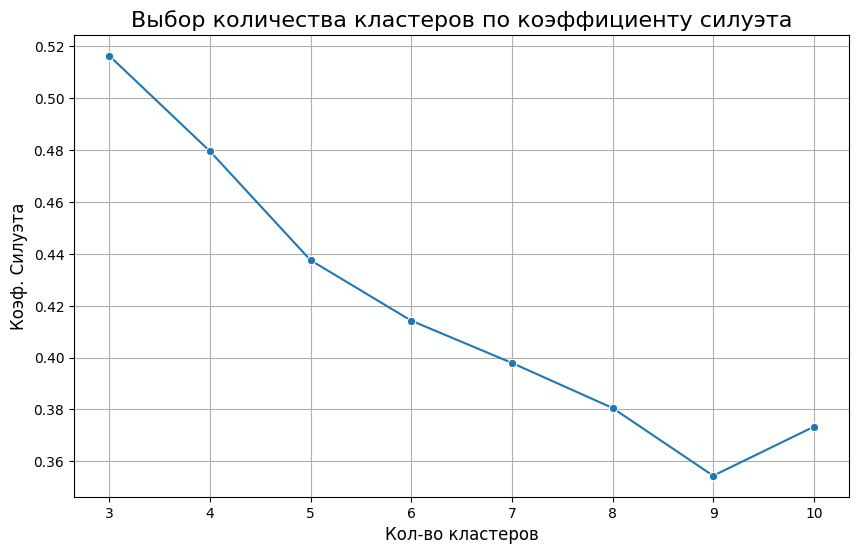

In [89]:
silhouette_scores = []

for n in range(3,11):
    kmeans = KMeans(n_clusters=n, random_state=42)
    clusters = kmeans.fit_predict(rfm)
    silhouette_scores.append(silhouette_score(rfm, clusters))

line_silhouette_score(silhouette_scores)

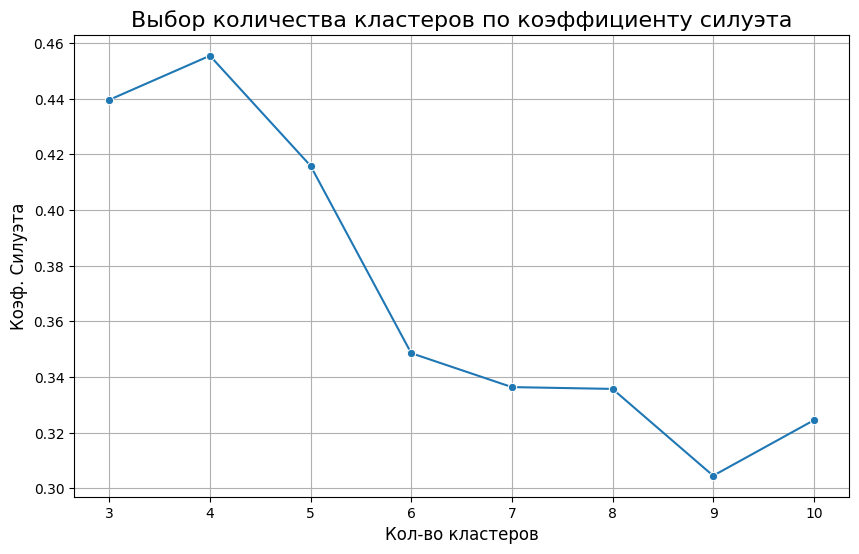

In [90]:
silhouette_scores = []

for n in range(3,11):
    model = AgglomerativeClustering(n_clusters=n)
    clusters = model.fit_predict(rfm)
    silhouette_scores.append(silhouette_score(rfm, clusters))

line_silhouette_score(silhouette_scores)

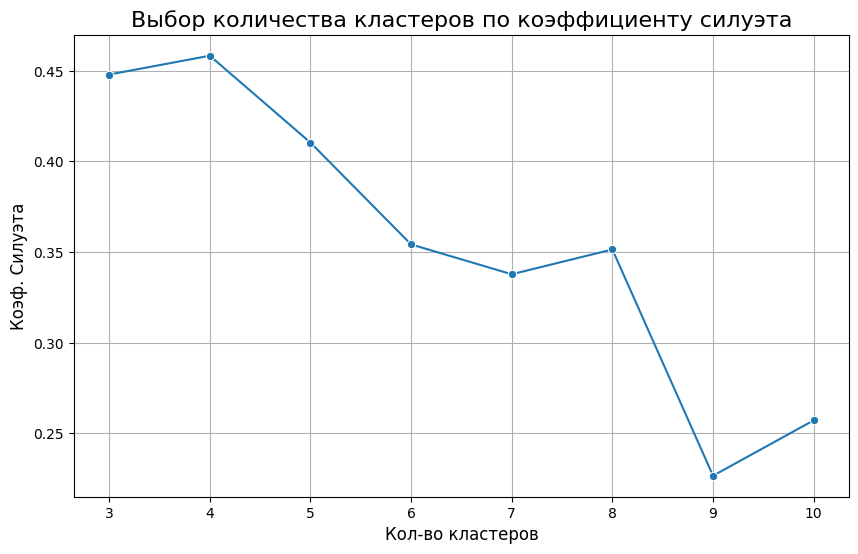

In [91]:
silhouette_scores = []
for n in range(3,11):
    model = SpectralClustering(n_clusters=n, random_state=42)
    clusters = model.fit_predict(rfm)
    silhouette_scores.append(silhouette_score(rfm, clusters))

line_silhouette_score(silhouette_scores)


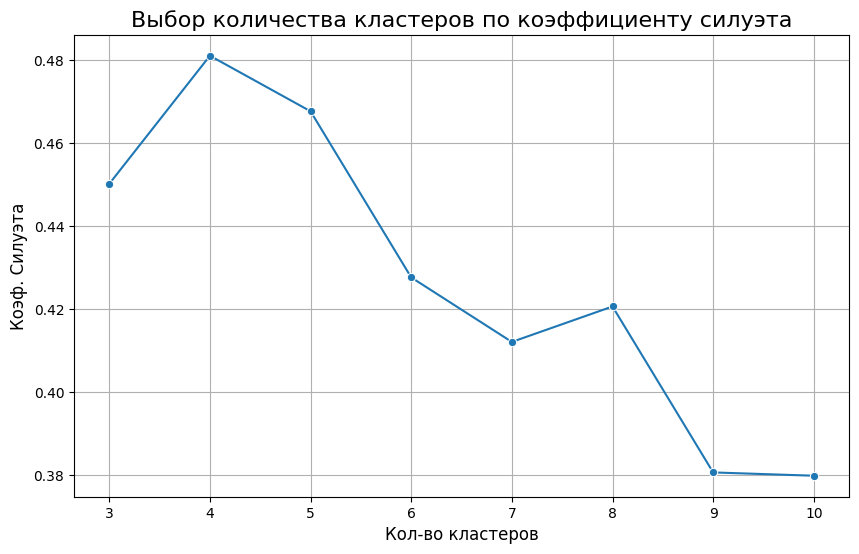

In [92]:
silhouette_scores = []

for n in range(3,11):
    model = Birch(n_clusters=n)
    clusters = model.fit_predict(rfm)
    silhouette_scores.append(silhouette_score(rfm, clusters))

line_silhouette_score(silhouette_scores)

In [93]:
def evaluate_dbscan(params: dict) -> float:
    """Оценивает качество кластеризации данных с помощью алгоритма DBSCAN."""

    eps = params['eps']
    min_samples = params['min_samples']
    model = DBSCAN(eps=eps, min_samples=min_samples)
    clusters = model.fit_predict(rfm)
    if (len(set(clusters)) > 2) and (len(set(clusters)) <= 10):  
        score = silhouette_score(rfm, clusters)
        print(score)
    else:
        print(score)
        score = -1  # Если нет кластеров, присваиваем отрицательный балл
    return score

param_dist = {
    'eps': uniform(loc=0.1, scale=1.0),
    'min_samples': np.arange(2, 20, 2)
}



random_search = RandomizedSearchCV(
    estimator=DBSCAN(),
    param_distributions=param_dist,
    n_iter=100,
    scoring=evaluate_dbscan,
    cv=3,
    random_state=42,
    n_jobs=-1
)

random_search.fit(rfm)


print(f"Best Score: {random_search.best_score_}")
print(f"Best Parameters: {random_search.best_params_}")

Best Score: nan
Best Parameters: {'eps': 0.47454011884736247, 'min_samples': 16}


DBSCAN не смогл выявить ни одной комбинации, при которой количество кластеров было бы больше двух. Из этого можно сделать вывод что ввиду плотности данных матеоды наоснове плотности будут работать некорректно, ввиду чего их проверять не будем 

#### Больше всего по силуэту подходят `Kmean` с 3 кластерами, и `Birch` с 4, посмотрим как они разбили кластеры

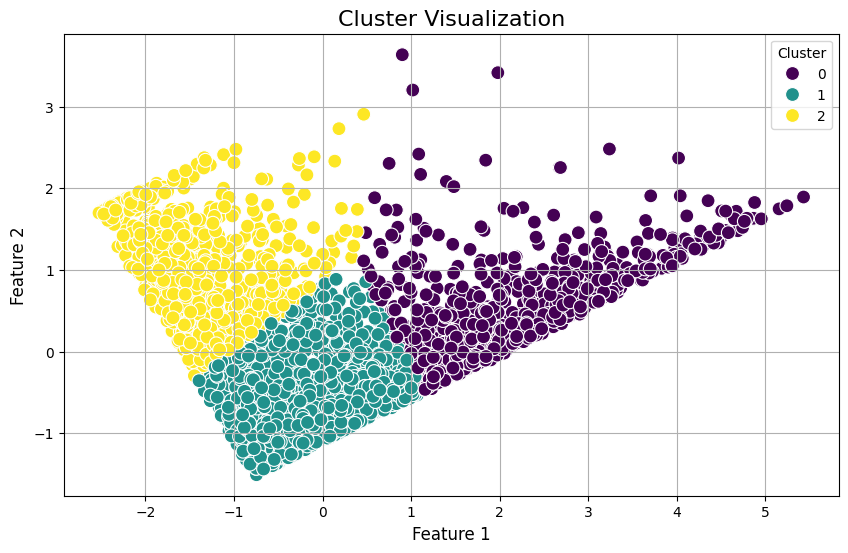

In [94]:
model = KMeans(n_clusters=3, random_state=42)
scatter_px(rfm, model.fit_predict(rfm))

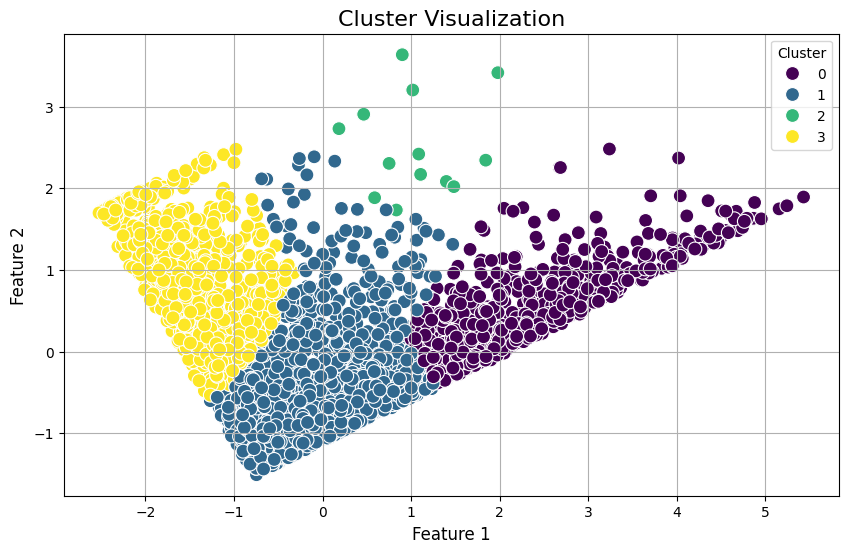

In [95]:
model = Birch(n_clusters=4)
scatter_px(rfm, model.fit_predict(rfm))

##### Как можно заметить, `Birch` выделил данные похожие на шум в отдельный кластер. Дальнейшую 3D визуализацию я буду проводить одновременно с `KMEANS` и `Birch`


### 3.2. Интерпретация результатов кластеризации

Перейдём к интерпретации полученных кластеров.

#### 3.2.1. Визуализация кластеров

In [96]:
def scatter_3d_rfm(data: pd.DataFrame) -> None:
    """Строит 3D график кластеризации по Recency, Frequency и Monetary."""

    # Создаем фигуру и 3D ось
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection='3d')

    # Разделяем данные по кластерам для разных цветов
    scatter = ax.scatter(data['Recency'], data['Frequency'], data['Monetery'], 
                         c=data['clusters'], cmap='viridis', s=50)

    # Настраиваем оформление графика
    ax.set_title('3D Cluster Visualization', fontsize=16)
    ax.set_xlabel('Recency', fontsize=12)
    ax.set_ylabel('Frequency', fontsize=12)
    ax.set_zlabel('Monetary', fontsize=12)
    
    # Добавляем цветовую шкалу
    cbar = plt.colorbar(scatter)
    cbar.set_label('Clusters', fontsize=12)
    
    plt.show()

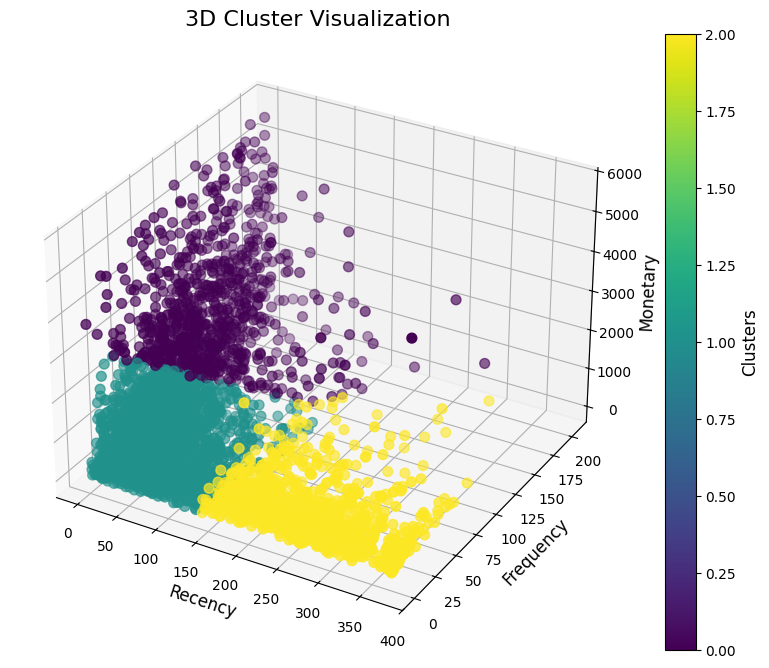

In [97]:
model = KMeans(n_clusters=3, random_state=42)
main_rfm['clusters'] = model.fit_predict(rfm)

scatter_3d_rfm(main_rfm)

## Описание групп клиентов

### Жёлтые (спящие клиенты)
- Эти пользователи не совершали заказов в среднем более **150 дней**.
- Демонстрируют относительно низкие показатели расходов.
- Представляют собой группу, которая, возможно:
  - Утратила интерес к покупкам.
  - Имеет низкую лояльность.

### Зелёные (средние пользователи)
- Клиенты, совершавшие заказы в последние **150 дней**.
- Обладают умеренными показателями затрат (Monetary).
- Их покупательская активность схожа с жёлтыми клиентами по показателю уникальности покупок, но они остаются более активными.

### Фиолетовые (лояльные клиенты)
- Эта группа принесла наибольший доход магазину.
- Варируются по частоте покупок (Frequency) и, как правило, совершают покупки регулярно.
- Тем не менее, среди них есть несколько клиентов, которые:
  - Совершали покупки давно, что можно считать выбросами.


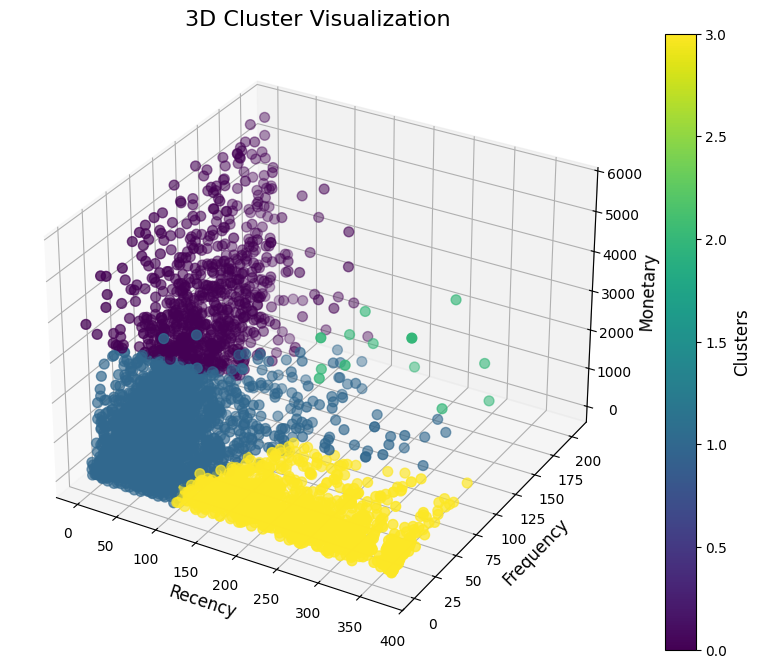

In [98]:
model = Birch(n_clusters=4)
main_rfm['clusters'] = model.fit_predict(rfm)

scatter_3d_rfm(main_rfm)

## Основная идея
- **Birch** использует тот же подход, что и **KMeans**, но с важным отличием:
  - Клиенты, которые когда-то совершали крупные покупки, но давно не пользовались услугами магазина, выделяются в отдельный кластер.

## Выбор метода
- Хотя **Birch** уступает **KMeans** по "коэффициенту силуэта", я считаю его более подходящим для бизнеса. 
- Это связано с тем, что **Birch**:
  - Выделяет клиентов, которые потенциально могут принести значительную прибыль, но по какой-то причине давно не пользовались услугами магазина.
  - Для таких клиентов можно разработать специальные предложения, например:
    - Дополнительные услуги.
    - Скидки.
    - Другие стимулы.


#### 3.2.2. Построение профиля кластеров

In [104]:

def plot_cluster_profile(grouped_data: pd.DataFrame, n_clusters: int) -> None:
    """Функция для визуализации профиля кластеров в виде полярной диаграммы."""
    
   
    scaler = MinMaxScaler()
    normalized_data = pd.DataFrame(scaler.fit_transform(grouped_data), columns=grouped_data.columns)

    angles = np.linspace(0, 2 * np.pi, len(normalized_data.columns), endpoint=False).tolist()
    
    fig, ax = plt.subplots(figsize=(8, 8), subplot_kw=dict(polar=True))

    for i in range(n_clusters):
        values = normalized_data.iloc[i].values.flatten().tolist()
        values += values[:1] 
        
        
        angles_with_closure = angles + [angles[0]]  
        
        ax.plot(angles_with_closure, values, label=f'Cluster {i}')
        ax.fill(angles_with_closure, values, alpha=0.25)  

    
    ax.set_yticklabels([])
    ax.set_xticks(angles)
    ax.set_xticklabels(normalized_data.columns)  
    ax.set_title('Профиль кластеров', size=16)
    ax.legend(loc='upper right', bbox_to_anchor=(1.1, 1.1))

    plt.show()


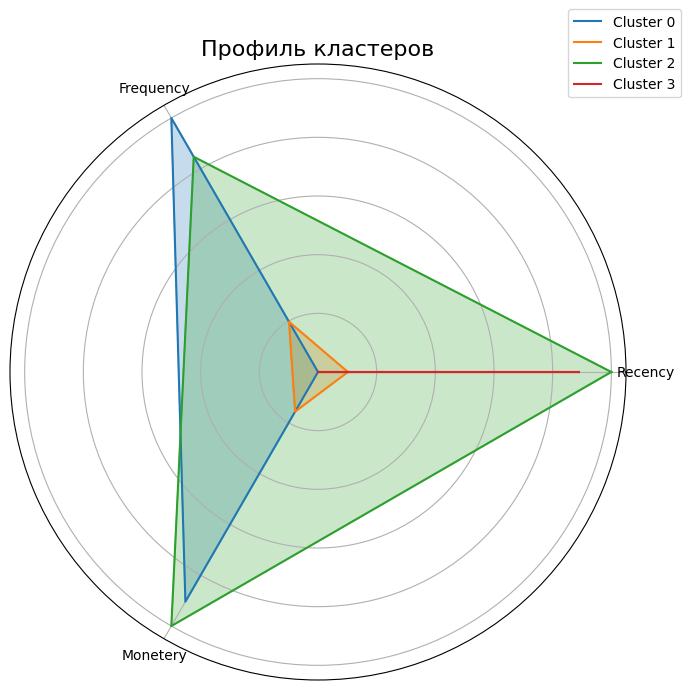

In [105]:
group_rfm = main_rfm.groupby('clusters').mean()
plot_cluster_profile(group_rfm, 4)

## 5. Выводы и оформление работы

## Сегментация клиентов

В ходе выполненной работы были успешно сегментированы клиенты на основе их покупательского поведения. Анализ позволил выявить четыре основных сегмента:

### 1. Лояльные клиенты (cl0)
- Эти клиенты регулярно совершают покупки и приносят значительную прибыль магазину.

### 2. Клиенты в зоне риска (cl1)
- Недавно совершали покупки, но приносят средний доход.
- Эта группа требует особого внимания для поддержания их интереса к продуктам и услугам магазина.

### 3. Бывшие активные клиенты (cl2)
- Ранее они принадлежали к числу лояльных клиентов, но по какой-то причине давно не совершали покупок.
- Эти клиенты имеют высокий потенциал, и для их возвращения в активные покупатели целесообразно предложить специальные акции и предложения.

### 4. Спящие клиенты (cl3)
- Эти клиенты давно не совершали покупок, и их активность в магазине минимальна.
- Это наиболее пассивный сегмент, который может потребовать значительных усилий для повторной активации.

## Выводы
Использование алгоритма `Birch`, несмотря на его менее высокий коэффициент силуэта по сравнению с `KMeans`, позволило более эффективно выделить клиентов, которые могут представлять высокий бизнес-потенциал, несмотря на снижение активности. Это позволяет нацелить маркетинговые усилия на возврат клиентов и удержание тех, кто находится в зоне риска.
